<a href="https://colab.research.google.com/github/matteo-cutroni/CV-project/blob/main/Efficient_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [1]:
!git clone https://github.com/brownvc/R3GAN.git
!pip install click requests tqdm pyspng ninja imageio-ffmpeg==0.4.3 scipy

Cloning into 'R3GAN'...
remote: Enumerating objects: 134, done.
remote: Counting objects: 100% (63/63), done.
remote: Compressing objects: 100% (32/32), done.
remote: Total 134 (delta 33), reused 31 (delta 31), pack-reused 71 (from 1)
Receiving objects: 100% (134/134), 172.52 KiB | 8.63 MiB/s, done.
Resolving deltas: 100% (57/57), done.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.9/26.9 MB 84.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.6/194.6 kB 21.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 180.7/180.7 kB 15.5 MB/s eta 0:00:00
  Attempting uninstall: imageio-ffmpeg
    Found existing installation: imageio-ffmpeg 0.6.0
    Uninstalling imageio-ffmpeg-0.6.0:
      Successfully uninstalled imageio-ffmpeg-0.6.0


In [2]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

import torch.optim as optim

import matplotlib.pyplot as plt
from torchvision.utils import make_grid

import sys
import os

if os.path.exists("R3GAN"):
    sys.path.append("R3GAN")

import R3GAN.FusedOperators
import R3GAN.Resamplers

print("Patching R3GAN to use safe Python implementations...")

# Force BiasedActivation to use the Reference (Python) version
R3GAN.FusedOperators.BiasedActivation = R3GAN.FusedOperators.BiasedActivationReference

# Force Resamplers to use the Reference (Python) versions
R3GAN.Resamplers.InterpolativeUpsampler = R3GAN.Resamplers.InterpolativeUpsamplerReference
R3GAN.Resamplers.InterpolativeDownsampler = R3GAN.Resamplers.InterpolativeDownsamplerReference
R3GAN.Resamplers.InplaceUpsampler = R3GAN.Resamplers.InplaceUpsamplerReference
R3GAN.Resamplers.InplaceDownsampler = R3GAN.Resamplers.InplaceDownsamplerReference

print("✅ Patch applied! You can now run your Training Loop without compilation errors.")

from training.networks import Generator, Discriminator
from R3GAN.Trainer import AdversarialTraining


cuda
Patching R3GAN to use safe Python implementations...
✅ Patch applied! You can now run your Training Loop without compilation errors.


# Hyperparameters

In [3]:
BATCH_SIZE = 64
IMAGE_SIZE = 32
CHANNELS_IMG = 3
G_LR = 1e-4          # Learning rate for Generator
D_LR = 1e-4          # Learning rate for Discriminator
NUM_EPOCHS = 100

# preset for CIFAR10 found in train.py of R3GAN
WidthPerStage = [3 * x // 4 for x in [1024, 1024, 1024, 1024]]
BlocksPerStage = [2 * x for x in [1, 1, 1, 1]]
CardinalityPerStage = [3 * x for x in [32, 32, 32, 32]]
FP16Stages = [-1, -2, -3]
NoiseDimension = 64

# kwargs used in official R3GAN repo
common_kwargs = {
    "NoiseDimension": NoiseDimension,
    "c_dim": 0,
    "img_resolution": IMAGE_SIZE,
    "WidthPerStage": WidthPerStage,
    "CardinalityPerStage": CardinalityPerStage,
    "BlocksPerStage": BlocksPerStage,
    "ExpansionFactor": 2,
    "FP16Stages": FP16Stages
}
# adjust for discriminator
d_kwargs = common_kwargs.copy()
d_kwargs.pop("NoiseDimension")
d_kwargs["WidthPerStage"] = list(reversed(WidthPerStage))
d_kwargs["CardinalityPerStage"] = list(reversed(CardinalityPerStage))
d_kwargs["BlocksPerStage"] = list(reversed(BlocksPerStage))
d_kwargs["FP16Stages"] = [x + len(FP16Stages) for x in FP16Stages]

# Utils

In [4]:
def show_images(images):
    # reverse the normalization
    images = images * 0.5 + 0.5
    img_grid = make_grid(images, nrow=8)
    img_grid_np = img_grid.permute(1, 2, 0).cpu().numpy()

    plt.figure(figsize=(10, 10))
    plt.imshow(img_grid_np)
    plt.axis('off')
    plt.show()

# Dataset

In [5]:
# normalize in range [-1.0, 1.0]
transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(
        [0.5 for _ in range(CHANNELS_IMG)],
        [0.5 for _ in range(CHANNELS_IMG)]
    )
])

dataset = datasets.CIFAR10(
    root="dataset/",
    train=True,
    transform=transforms,
    download=True
)

dataloader = DataLoader(
    dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2 # num_workers=2 is recommended by Colab
)

100%|██████████| 170M/170M [00:03<00:00, 47.2MB/s]


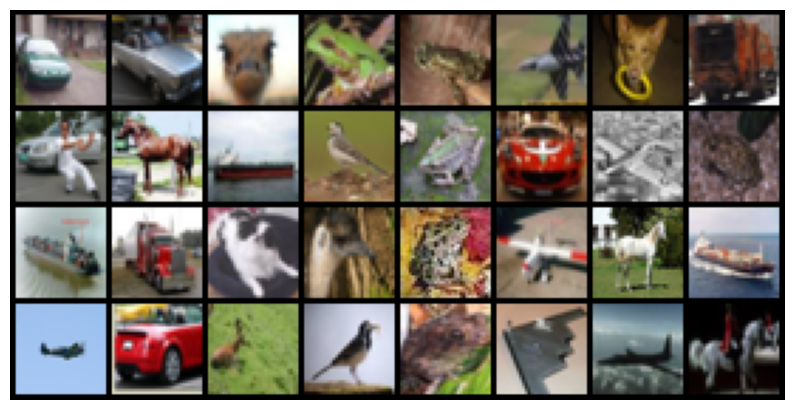

In [6]:
real_batch = next(iter(dataloader))
images, labels = real_batch

show_images(images[:32])

# Network

In [7]:
G = Generator(**common_kwargs).to(device)
D = Discriminator(**d_kwargs).to(device)

# make sure they are in training mode
G.train()
D.train()

# Note: 0.002 is a common starting LR for these advanced GANs
opt_G = optim.Adam(G.parameters(), lr=G_LR, betas=(0.0, 0.99))
opt_D = optim.Adam(D.parameters(), lr=D_LR, betas=(0.0, 0.99))

trainer = AdversarialTraining(G, D)

# Train

In [8]:
real_img, _ = next(iter(dataloader))
real_img = real_img.to(device)
# create noise
gen_z = torch.randn([BATCH_SIZE, NoiseDimension], device=device)

real_c = None

opt_D.zero_grad()

d_metrics = trainer.AccumulateDiscriminatorGradients(
    gen_z, real_img, real_c, Gamma=0.05, Scale=1
)
opt_D.step()

opt_G.zero_grad()
g_metrics = trainer.AccumulateGeneratorGradients(
    gen_z, real_img, real_c, Scale=1
)
opt_G.step()

print("✅ Single training step successful!")
print(f"D Loss: {d_metrics[0].mean().item():.4f}") # Adversarial Loss
print(f"G Loss: {g_metrics[0].mean().item():.4f}") # Generator Loss

✅ Single training step successful!
D Loss: 0.6734
G Loss: 1.1530
